# KITTI SE(2) Dead Reckoning with Bias Estimation (EKF)

We will estimate the state vector:
 
$$\mathbf{x} = [x, y, \psi, v, b_\omega, b_a]^T$$

where:
- $x, y$: position in the plane
- $\psi$: yaw
- $v$: forward speed
- $b_\omega$: gyro (yaw rate) bias
- $b_a$: accelerometer bias
The EKF has prediction and update steps using IMU measurements and (optionally) KITTI ground truth pose.

## Data Loading

In [6]:
import glob
import os
from datetime import datetime


import numpy as np
import pandas as pd
import pyproj
import matplotlib.pyplot as plt

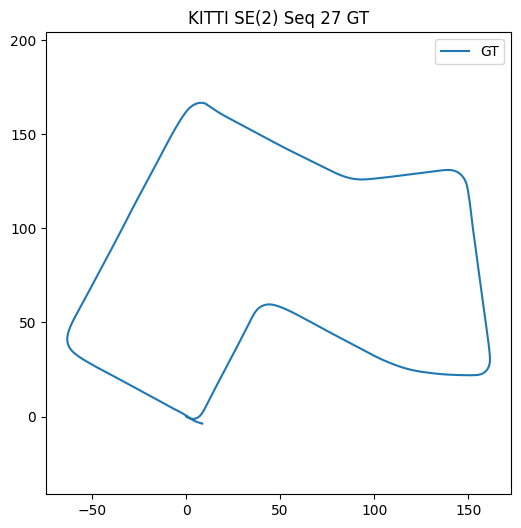

In [8]:
DATASET_LOCATION = "/media/saad/95237699-a090-4f1e-979d-e7bfa9412afc/datasets/kitti/2011_09_30"
DATASET_FILES = os.path.join(DATASET_LOCATION, "2011_09_30_drive_0027_sync/oxts/data/*.txt")
files = sorted(glob.glob(DATASET_FILES))

data = np.array([np.loadtxt(f) for f in files])




# Load timestamps
ts = []
with open(
    os.path.join(DATASET_LOCATION, "2011_09_30_drive_0027_sync/oxts/timestamps.txt")
) as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        if "." in line:
            head, frac = line.split(".")
            frac = frac[:6]  # keep microseconds
            line = f"{head}.{frac}"

        ts.append(
            datetime.strptime(line, "%Y-%m-%d %H:%M:%S.%f").timestamp()
        )

ts = np.array(ts)

proj = pyproj.Proj(proj="utm", zone=32, ellps="WGS84")

xs, ys = [], []
for lat, lon in data[:, :2]:
    x, y = proj(lon, lat)
    xs.append(x)
    ys.append(y)

xs = np.array(xs)
ys = np.array(ys)

# Make relative to start
xs -= xs[0]
ys -= ys[0]

yaw = data[:, 5]
v   = data[:, 8]
ax  = data[:, 11]
wz  = data[:, 19]


plt.figure(figsize=(6,6))
plt.plot(xs, ys, label="GT")
plt.axis("equal")
plt.legend()
plt.title("KITTI SE(2) Seq 27 GT")
plt.show()

## State

We define our state as:

$$\bf{x} = \begin{bmatrix}x\\y\\\psi\\v\\b_{\omega}\\b_a\end{bmatrix}$$

Here, $(x,y)$ is position, $\psi$ is yaw, $v$ is speed, $b_{\omega}$ is gyro bias, and $b_a$ is accelerometer bias.

## Motion model

This is how we define updates to our motion. Most of it is similar to our dead reckoning, but we incorporate our IMU biases:

$$\psi_{k+1} = \psi_k + (\omega_{z,k} - b_\omega) \Delta t$$
$$v_{k+1} = v_k + (a_{x,k} - b_a) \Delta t$$
$$x_{k+1} = x_k + v_k \cos \psi_k \Delta t$$
$$y_{k+1} = y_k + v_k \sin \psi_k \Delta t$$
$$b_{\omega,k+1} = b_{\omega,k},\quad b_{a,k+1} = b_{a,k}$$

## Noise models

We also define two matrices here, $P$ and $Q$.

### Covariance of the state: $P$

The covariance matrix $P$ tracks how uncertain we are about each component of the state, and how each error in the state is correlated with each other. This is something we compute at each timestamp. It is possible for an EKF to diverge if this covariance gets out of hand, which is why we have to make sure our next matrix, $Q$ is tuned properly.

### Process noise covariance $Q$

This matrix models the uncertaintly introduced during prediction, i.e. how noisy our IMUs are. We usually model this noise as a Gaussian process, and tune each model individually. Usually this comes from some spec sheet.


## Define EKF functions

### Prediction step

The prediction step takes our previous estimate and propagate it forward using our motion model (IMU readings) and current bias estimate, before seeing any new measurement. Our motion model is non-linear however, and we must propogate the covariance $P$ lineraly. So we linearize the function around the current estimate by computing a Jacobian, allowing us to propogate the errors through.

The prediction step is therefore the motion model update + the covariance prediction:

$$\psi_{k+1} = \psi_k + (\omega_{z,k} - b_\omega) \Delta t$$
$$v_{k+1} = v_k + (a_{x,k} - b_a) \Delta t$$
$$x_{k+1} = x_k + v_k \cos \psi_k \Delta t$$
$$y_{k+1} = y_k + v_k \sin \psi_k \Delta t$$
$$b_{\omega,k+1} = b_{\omega,k},\quad b_{a,k+1} = b_{a,k}$$

$$F_k = \begin{bmatrix}
1 & 0 & -v \sin \psi \Delta t & \cos \psi \Delta t & 0 & 0\\
0 & 1 & v \cos \psi \Delta t & \sin \psi \Delta t & 0 & 0 \\
0 & 0 & 1 & 0 & -\Delta t & 0 \\
0 & 0 & 0 & 1 & 0 & -\Delta t \\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1\\
\end{bmatrix}$$

$$P_{k+1|k} = F_k P_{k|k}F^T_k + Q$$

### Update step

$$z = [x^{GT}, y^{GT}, \psi^{GT}, v^{GT}]^T$$
$$h(x) = [x, y, \psi, v]^T$$
$$H = \begin{bmatrix} 1 &0&0&0&0&0\\0&1&0&0&0&0\\0&0&1&0&0&0\\0&0&0&1&0&0 \end{bmatrix}$$

In [10]:
# Q = process noise covariance
Q = np.diag([
    0.01,   # x process noise (m^2)
    0.01,   # y process noise (m^2)
    1e-4,   # yaw process noise (rad^2)
    0.1,    # velocity process noise (m/s)^2
    1e-6,   # gyro bias noise (rad^2)
    1e-5    # accel bias noise (m/s^2)^2
])

# P = initial state covariance
P = np.diag([
    1e-3,  # x initial uncertainty
    1e-3,  # y
    1e-3,  # psi
    1e-3,  # v
    1e-6,  # b_omega
    1e-6   # b_a
])

In [9]:
def ekf_predict(x, P, ax, wz, dt, Q):
    # Extract states
    x_pos, y_pos, psi, v, b_omega, b_a = x
    # Bias-corrected inputs
    omega = wz - b_omega
    a = ax - b_a
    # Predict state
    psi_pred = psi + omega*dt
    v_pred = v + a*dt
    x_pred = x_pos + v*np.cos(psi)*dt
    y_pred = y_pos + v*np.sin(psi)*dt
    b_omega_pred = b_omega
    b_a_pred = b_a
    x_pred_vec = np.array([x_pred, y_pred, psi_pred, v_pred, b_omega_pred, b_a_pred])
    # Jacobian F
    F = np.array([
        [1,0,-v*np.sin(psi)*dt, np.cos(psi)*dt, 0, 0],
        [0,1, v*np.cos(psi)*dt, np.sin(psi)*dt, 0, 0],
        [0,0,1,0,-dt,0],
        [0,0,0,1,0,-dt],
        [0,0,0,0,1,0],
        [0,0,0,0,0,1]
    ])
    # Covariance prediction
    P_pred = F @ P @ F.T + Q
    return x_pred_vec, P_pred

In [24]:
def ekf_update(x_pred, P_pred, z, H, R):
    y = z - H @ x_pred
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_upd = x_pred + K @ y
    P_upd = (np.eye(6) - K @ H) @ P_pred
    return x_upd, P_upd

In [25]:
x_est = np.zeros((len(ax),6)) # state history
P = np.eye(6) * 1e-3 # initial covariance

# Process noise covariance Q
# Tune these based on expected IMU noise
Q = np.diag([0.01, 0.01, 1e-4, 0.1, 1e-6, 1e-5])

# Measurement noise covariance R (for optional GT updates)
R = np.diag([0.01,0.01,1e-4,0.1])

# Initialize state
x_est[0,:4] = [0,0,yaw[0],v[0]]
x_est[0,4:] = [0,0] # initial biases zero

for k in range(1,len(ax)):
    dt = ts[k]-ts[k-1]

    # --- EKF prediction ---
    x_pred, P_pred = ekf_predict(x_est[k-1], P, ax[k-1], wz[k-1], dt, Q)

    # --- EKF update (only use available measurements) ---
    # Here we only have yaw and velocity
    z = np.array([x_pred[0], x_pred[1], yaw[k], v[k]])  # keep x/y as predicted
    H = np.array([
        [0,0,0,0,0,0],  # x (no measurement)
        [0,0,0,0,0,0],  # y (no measurement)
        [0,0,1,0,0,0],  # psi (we have measurement)
        [0,0,0,1,0,0]   # v
    ])
    R_mod = np.diag([1e-6, 1e-6, R[2,2], R[3,3]])  # tiny for x/y to keep them unchanged

    x_upd, P_upd = ekf_update(x_pred, P_pred, z, H, R_mod)
    x_est[k] = x_upd
    P = P_upd


0.4611630433471594


<Figure size 640x480 with 0 Axes>

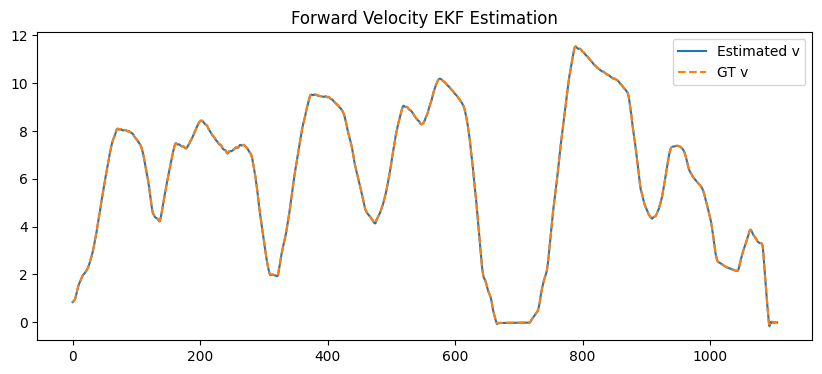

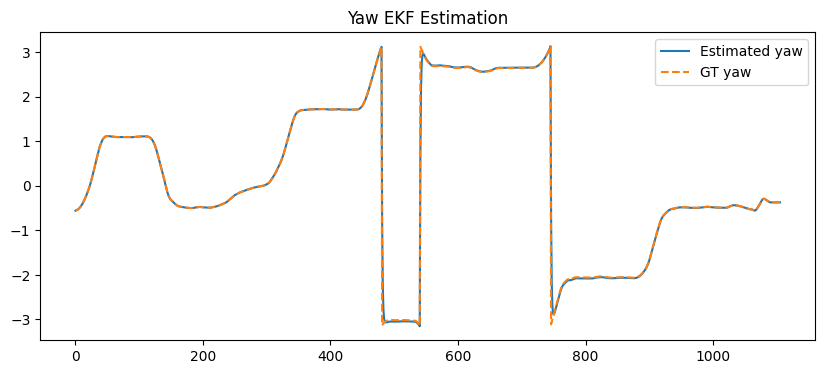

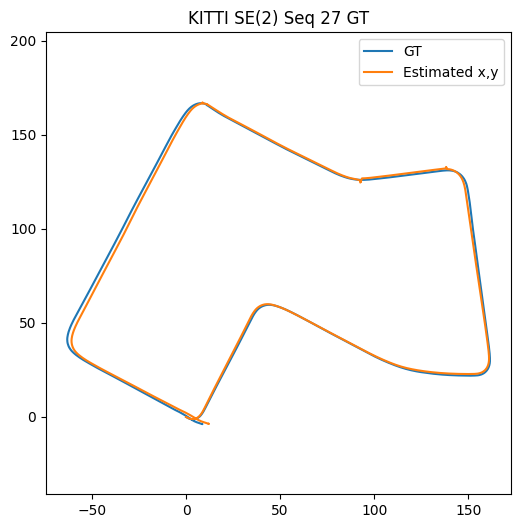

In [27]:
plt.clf()
plt.figure(figsize=(10,4))
plt.plot(x_est[:,3], label='Estimated v')
plt.plot(v, label='GT v', linestyle='--')
plt.legend()
plt.title('Forward Velocity EKF Estimation')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(x_est[:,2], label='Estimated yaw')
plt.plot(yaw, label='GT yaw', linestyle='--')
plt.legend()
plt.title('Yaw EKF Estimation')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(xs, ys, label="GT")
plt.plot(x_est[:, 0], x_est[:, 1], label="Estimated x,y")
plt.axis("equal")
plt.legend()
plt.title("KITTI SE(2) Seq 27 GT")
plt.show()


Incorporating velocity and absolute yaw fixes a lot of our issues with the trajectory! Now it matches the GT almost exactly.

The nice thing here is that we can include other measurements as well. Say we have LIDAR odometry or visual odometry from cameras. We can incorporate those measurements to get an exact estimate.

Note that it still isn't perfect -- we have a little bit of drift over time. We'll have to find another external signal to correct that. We can use GPS (which is also not exact, but considering the GT is GPS it will basically incorporate it)